# Introduction to Generative Adversarial Networks (GANs)

Une intro en français [Fidle: 2022/2023 Seq. 13 / Generative Adversarial Networks (GAN)](https://www.youtube.com/watch?v=hvFthCbTl5c)

## Generative models

$$    
\min_{G}\max_{D} \mathrm{Loss}(D, G) = \mathbb{E}_{x\sim z_{\mathrm{data}}}\left[\log D(x)\right]
    +\mathbb{E}_{x\sim f_z}\left[\log \left( 1-D(G(z))\right)\right]
$$

A GAN is a neural network based structure used to generate data that has similar properties to some existing target data set. Most commonly this data set is for images but in this case is a time series. 
The structure is composed of two functions:
1. Generator $G$
- Input: Gaussian noise
- Output: data of the same dimensions as a batch of the target set 
- Goal: the generated data has similar properties to the data set and could be confused with data from this target set. 
2. Discriminator $D$
 - Input: data batch - either generated or from target set
 - Output: probability that this batch belongs to the target data set. 
 - Goal: Distinguish between batches from the target data set (output close to 1) and those that have been generated by the Generator (output close to 0).

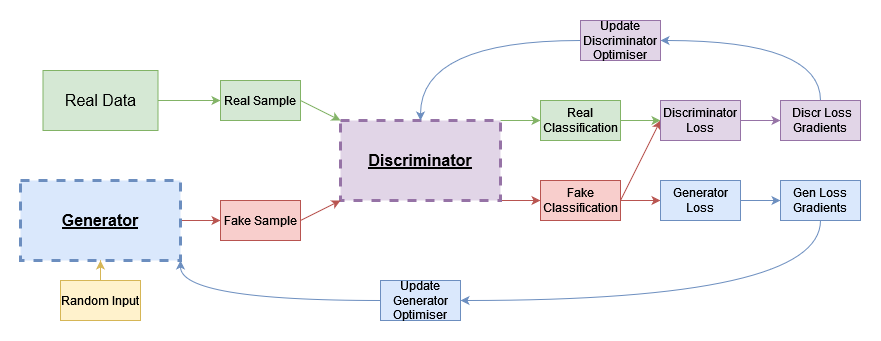

# GAN with Flux

## GAN Packages & Functions

### Packages and functions for Neural Networks

In [1]:
using Base.Iterators: partition
using Flux
using Flux.Optimise: update!
using Flux.Losses: logitbinarycrossentropy
using Flux: params

### Hyperparamers

In [2]:
Base.@kwdef struct HyperParams_ex_1
    batch_size::Int = 256
    latent_dim::Int = 1
    epochs::Int = 500
    verbose_freq::Int = 100
    lr_dscr::Float32 = 0.0002
    lr_gen::Float32 = 0.0002
end

HyperParams_ex_1

### Discriminator and Generator

In [3]:
function Discriminator(features)
    return Chain(
            Dense(features, 64, sigmoid),
            Dense(64,1)
            )	
end

Discriminator (generic function with 1 method)

In [4]:
function Generator(latent_dim, features)
    return Chain(
            Dense(latent_dim, features)
            )
end

Generator (generic function with 1 method)

### Loss functions

In [5]:
function discriminator_loss(real_output, fake_output)
    real_loss = logitbinarycrossentropy(real_output, 1)
    fake_loss = logitbinarycrossentropy(fake_output, 0)
    return real_loss + fake_loss
end

generator_loss(fake_output) = logitbinarycrossentropy(fake_output, 1)

generator_loss (generic function with 1 method)

### Training functions

In [6]:
function train_discriminator!(gen, dscr, x, opt_dscr, hparams)
    noise = randn!(similar(x, (hparams.latent_dim, hparams.batch_size))) 
    fake_input = gen(noise)
    # Taking gradient
    loss, grads = Flux.withgradient(dscr) do dscr
        discriminator_loss(dscr(x), dscr(fake_input))
    end
    update!(opt_dscr, dscr, grads[1])
    return loss
end

function train_generator!(gen, dscr, x, opt_gen, hparams)
    noise = randn!(similar(x, (hparams.latent_dim, hparams.batch_size))) 
    # Taking gradient
    loss, grads = Flux.withgradient(gen) do gen
        generator_loss(dscr(gen(noise)))
        # generator_loss(pdf.(dist, gen(noise))) # One can try that in exemple 1, basically iit is a perfectly trained discriminator
    end
    update!(opt_gen, gen, grads[1])
    return loss
end

train_generator! (generic function with 1 method)

In [7]:
function train(training_X, hparams; N_output = 10_000)

    device = cpu # if you have GPU `device = gpu`
    # if CUDA.functional()
    #     @info "Training on GPU"
    # else
        @warn "Training on CPU, this will be very slow!"  # 20 mins/epoch
    # end
    N = size(training_X, 2)

    # Partition training data into batches
    data = [training_X[:, r] |> device for r in partition(1:N, hparams.batch_size)]

    features = size(training_X, 1)
    
    # Fixe noise that we will use to vizualize our generator output during the training
    fixed_noise = randn(Float32, hparams.latent_dim, N_output)
    
    dict_res = Dict() # Where we will store the results

    
    # Discriminator
    dscr = Discriminator(features) |> device

    # Generator
    gen =  Generator(hparams.latent_dim, features) |> device

    # Optimizers 
    opt_dscr = Flux.setup(Adam(hparams.lr_dscr), dscr)
    opt_gen = Flux.setup(Adam(hparams.lr_gen), gen)

    # Training
    train_steps = 0

    # Where we will store the losses
    LOSS_gen = Float32[]
    LOSS_disc = Float32[]
    
    for ep in 1:hparams.epochs
        # @info "Epoch $ep" # uncomment to get a print at each epochs
        for x in data
            # Update discriminator and generator
            loss_dscr = train_discriminator!(gen, dscr, x, opt_dscr, hparams)
            loss_gen = train_generator!(gen, dscr, x, opt_gen, hparams)
            train_steps += 1

            if train_steps % hparams.verbose_freq == 0
                # @info("Train step $(train_steps), Discriminator loss = $(loss_dscr), Generator loss = $(loss_gen)") # uncomment to get a print 
                dict_res[train_steps] = gen(fixed_noise)
                push!(LOSS_gen, loss_gen)
                push!(LOSS_disc, loss_dscr)
            end
        end
    end

    return sort(dict_res), gen, dscr, LOSS_gen, LOSS_disc
end

train (generic function with 1 method)

## Additional Settings

Packages to generate and plot data

In [8]:
using Statistics
using Random
using Distributions
using Plots

In [9]:
Random.seed!(1234)

TaskLocalRNG()

## Example 1: A GAN to learn a Normal distribution

### Data generation

In [10]:
N = 256*100

25600

In [11]:
dist = Normal{Float32}(5f0,1f0)
features = 1
training_X = rand(dist, features, N)

1×25600 Matrix{Float32}:
 4.64027  6.08721  4.58041  5.71891  …  5.42628  5.42965  5.87081  5.58497

### Training

In [12]:
hparams = HyperParams_ex_1(batch_size = 256, latent_dim = 1, epochs = 350, lr_dscr = 0.02)#, lr_gen = 0.02)

HyperParams_ex_1(256, 1, 350, 100, 0.02f0, 0.0002f0)

In [13]:
@time d, gen, dscr, lg, ld = train(training_X, hparams)

┌ Warning: Training on CPU, this will be very slow!
└ @ Main c:\Users\metivier\Dropbox\PC (2)\Documents\Simulations\NeuralNet\DCGAN\notebook_5_GAN.ipynb:7


 24.586775 seconds (35.84 M allocations: 35.876 GiB, 7.59% gc time, 38.23% compilation time: <1% of which was recompilation)


(OrderedCollections.OrderedDict{Any, Any}(100 => Float32[1.4351336 -0.96565884 … -1.5468334 0.66659856], 200 => Float32[1.5083531 -0.97597194 … -1.5773678 0.71307784], 300 => Float32[1.582925 -0.98833865 … -1.6107801 0.7598192], 400 => Float32[1.6534455 -0.99868673 … -1.6407046 0.80445224], 500 => Float32[1.7238798 -1.0099362 … -1.6717279 0.8487382], 600 => Float32[1.7888744 -1.0183485 … -1.6979102 0.8902339], 700 => Float32[1.8528676 -1.0270863 … -1.7242545 0.93094474], 800 => Float32[1.9114945 -1.0333809 … -1.746265 0.96878916], 900 => Float32[1.970008 -1.0403285 … -1.7690593 1.0063474], 1000 => Float32[2.0238936 -1.0451097 … -1.7880423 1.0414528]…), Chain(Dense(1 => 1)), Chain(Dense(1 => 64, σ), Dense(64 => 1)), Float32[8.357009, 10.492816, 11.514808, 11.832388, 12.552426, 12.378215, 12.488027, 11.447638, 11.913241, 10.872993  …  0.6925276, 0.6926423, 0.6938457, 0.69374645, 0.6928252, 0.69354665, 0.6930267, 0.69342566, 0.6930629, 0.6934604], Float32[0.024671737, 0.016757194, 0.01671

### Show results

┌ Info: Saved animation to C:\Users\metivier\AppData\Local\Temp\jl_bkJ4z2lep6.gif
└ @ Plots C:\Users\metivier\.julia\packages\Plots\sxUvK\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\metivier\\AppData\\Local\\Temp\\jl_bkJ4z2lep6.gif")
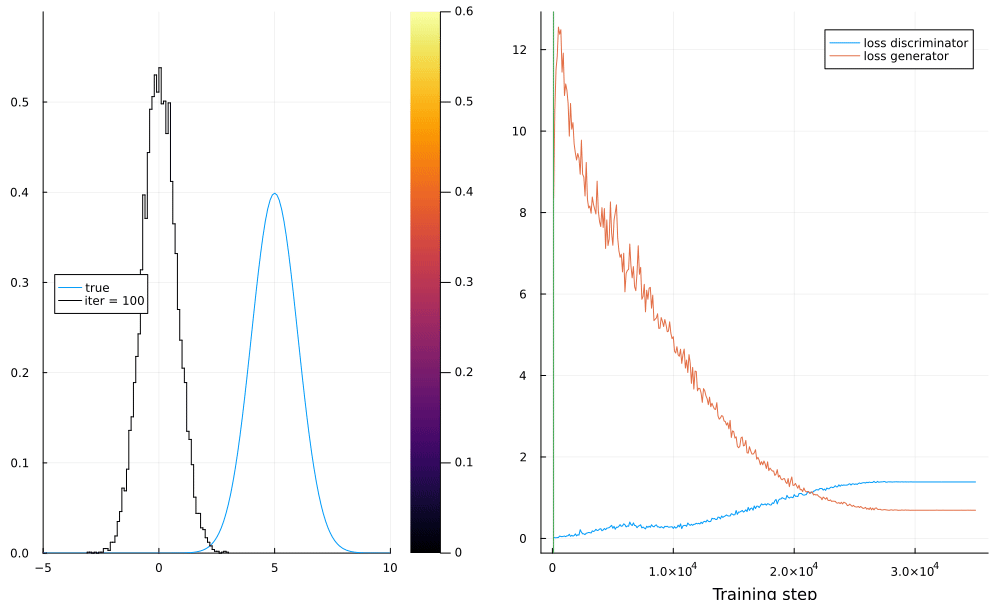

In [14]:
let
    x = -5:0.1:10
    steps = first(d)[1]:(last(d)[1]÷length(d)[1]):last(d)[1]
    a = @animate for (t, val) in d
        phist = plot(x, pdf.(dist, x), label = "true", legend = :left)
        stephist!(val', label = "iter = $(t)", norm = :pdf, line_z =  pdf.(dist, (val)'), clims = (0,0.6))
        xlims!(-5,10)
        ylims!(0,0.6)
        ploss = plot(steps, [ld,lg], label = ["loss discriminator" "loss generator"])
        vline!(ploss,[t], label = :none)
        xlabel!("Training step")
        plot(phist, ploss, size = (1000,600))
    end
    gif(a, fps=15)
end

## Example 2: A GAN to learn a 2D-distribution

In [15]:
using Copulas

In [16]:
dists = [Normal{Float32}(5f0,1f0), Exponential{Float32}(2f0)]
features = length(dists)

# independant distributions
# training_X = rand(product_distribution(dists), N) .|> Float32

# GaussianCopula 
ρ = 0.5
Σ = [1 ρ
    ρ 1]
C = GaussianCopula(Σ)
𝔇 = SklarDist(C, tuple(dists...)) 
training_X = rand(𝔇, N) .|> Float32

2×25600 Matrix{Float32}:
 6.10399  5.67773  4.68614  4.92978  …  4.54349  2.26651     5.00619
 1.93814  9.31515  3.46748  4.27217     0.47375  0.00443244  0.347904

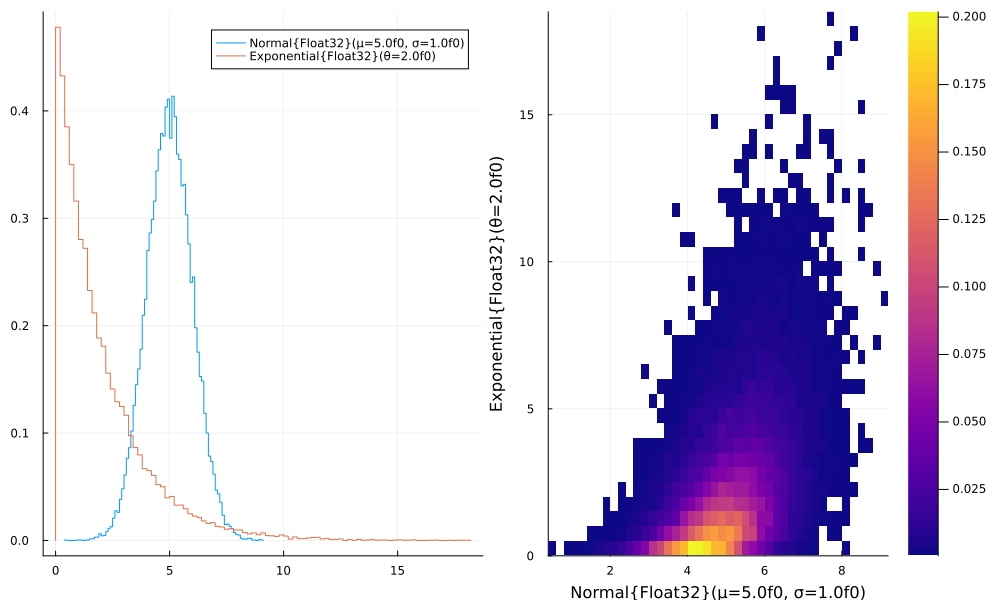

In [17]:
let 
    p_marginal = stephist(training_X', label = string.(permutedims(dists)), norm = :pdf)
    p_hist2D = histogram2d(training_X[1,:],training_X[2,:], xlabel = dists[1], ylabel = dists[2], color=:plasma, norm = :pdf)
    plot(p_marginal, p_hist2D, size = (1000,600))
end

### Training

In [18]:
# New generator to learn more complex function (like Exponential)
function Generator(latent_dim, features)
    return Chain(
        Dense(latent_dim, 64, sigmoid),
        Dense(64, features)
            )
end

Generator (generic function with 1 method)

Play with `latent_dim`. With `latent_dim = 1` it hardly work, with `latent_dim = 2` it works easily.

In [19]:
hparams = HyperParams_ex_1(batch_size = 256, latent_dim = 2, epochs = 350, lr_dscr = 0.02)

HyperParams_ex_1(256, 2, 350, 100, 0.02f0, 0.0002f0)

In [20]:
@time d, gen, dscr, lg, ld = train(training_X, hparams)

┌ Warning: Training on CPU, this will be very slow!
└ @ Main c:\Users\metivier\Dropbox\PC (2)\Documents\Simulations\NeuralNet\DCGAN\notebook_5_GAN.ipynb:7


 24.938954 seconds (16.50 M allocations: 52.080 GiB, 9.11% gc time, 0.96% compilation time: 12% of which was recompilation)


(OrderedCollections.OrderedDict{Any, Any}(100 => Float32[0.29664293 0.30357024 … 0.2895743 0.29571548; -0.11188414 -0.103056245 … -0.11754397 -0.11127635], 200 => Float32[1.2510899 1.2622796 … 1.2417109 1.2509953; 0.7605638 0.7736573 … 0.7525578 0.7619002], 300 => Float32[2.3605664 2.3714063 … 2.3507488 2.360798; 0.9921184 1.002171 … 0.9856825 0.9932355], 400 => Float32[3.3823478 3.3694022 … 3.382723 3.3800595; 0.52930075 0.5469653 … 0.5201662 0.53155255], 500 => Float32[3.9377534 3.910317 … 3.9444277 3.9341884; 0.35240698 0.48555517 … 0.29174957 0.36892876], 600 => Float32[4.170253 4.1422567 … 4.1756997 4.1668215; 0.38344526 0.7532804 … 0.20942193 0.42499912], 700 => Float32[4.3177695 4.30406 … 4.315678 4.315919; 0.47602797 0.9082443 … 0.2702448 0.5232885], 800 => Float32[4.408609 4.418174 … 4.3941 4.4088717; 0.54165006 1.020346 … 0.31184763 0.59303313], 900 => Float32[4.4840474 4.523726 … 4.4529285 4.4866443; 0.61835086 1.1404902 … 0.36557442 0.67336696], 1000 => Float32[4.5575147 4.

### Results

┌ Info: Saved animation to C:\Users\metivier\AppData\Local\Temp\jl_JoZ2zOtaLW.gif
└ @ Plots C:\Users\metivier\.julia\packages\Plots\sxUvK\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\metivier\\AppData\\Local\\Temp\\jl_JoZ2zOtaLW.gif")
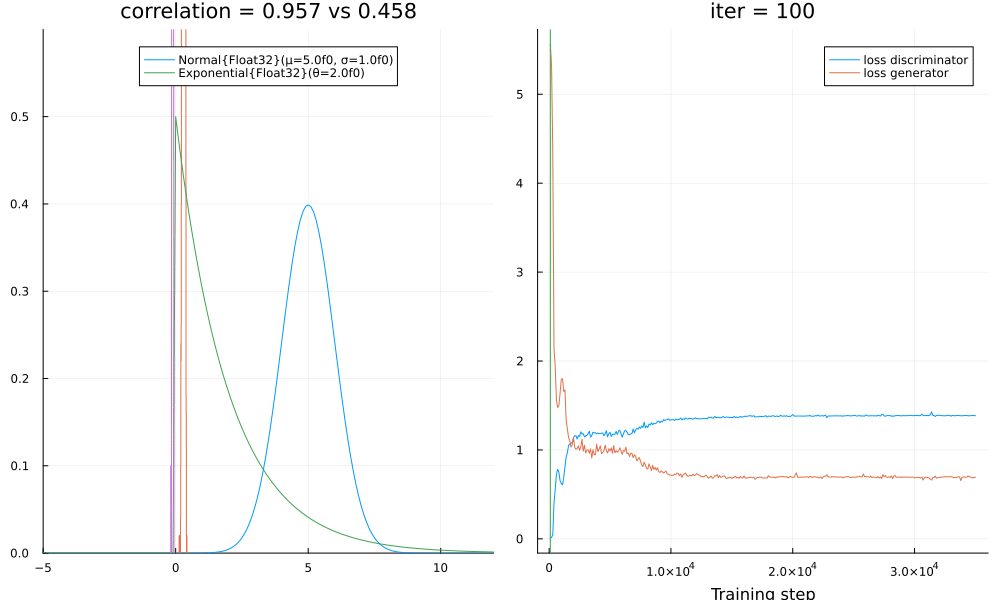

In [21]:
let
    x = -5:0.1:12
    cor_true = round(cor(training_X[1,:], training_X[2,:]), digits = 3)
    steps = first(d)[1]:(last(d)[1]÷length(d)[1]):last(d)[1]
    a = @animate for (t, val) in d
        phist = plot()
        for (i, di) in enumerate(dists)
            plot!(x, pdf.(di, x), label = "$di", legend = :top)
            stephist!(val[i,:], label = :none, norm = :pdf)#, line_z = pdf.(di, val[i,:]), clims = (0,0.6))
        end
        title!("correlation = $(round(cor(val[1,:],val[2,:]), digits = 3)) vs $cor_true")
        xlims!(x[1],x[end])
        ylims!(0,0.6)
        ploss = plot(steps, [ld,lg], label = ["loss discriminator" "loss generator"])
        vline!(ploss,[t], label = :none)
        xlabel!("Training step")
        title!("iter = $t")
        plot(phist, ploss, size = (1000,600))
    end
    gif(a, fps=15)
end

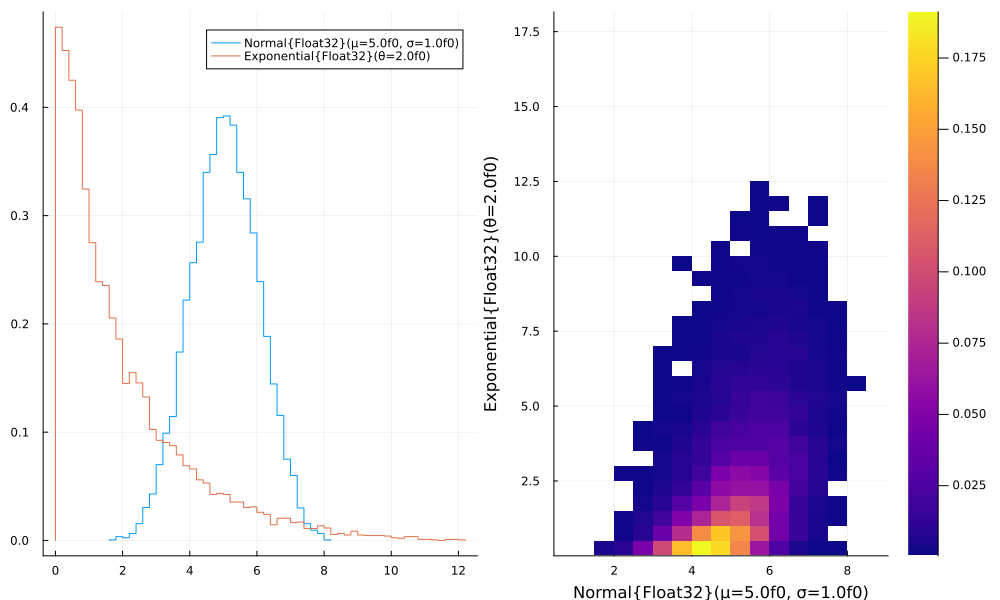

In [26]:
let 
    step = 35_000
    p_marginal = stephist(d[step]', label = string.(permutedims(dists)), norm = :pdf)
    p_hist2D = histogram2d(d[step][1,:],d[step][2,:], xlabel = dists[1], ylabel = dists[2], color=:plasma, norm = :pdf)
    xlims!(extrema(training_X[1,:]))
    ylims!(extrema(training_X[2,:]))
    plot(p_marginal, p_hist2D, size = (1000,600))
end